In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

np.random.seed(0)

In [3]:
sampled = np.load('sampled_2D_wider.npy')

In [109]:
sampled = np.array(sampled, dtype = np.float32)

In [38]:
data = sampled[0:1000]

In [6]:
k = 4
d = 2

In [8]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights):

    n_clus = len(weights)
    
    for h in range(n_clus):
        clusdata = data[cluster_allocs == h]
        if len(clusdata) == 0:
            uniq_vals[h, :] = sample_uniq_vals_prior()
        else:
            uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata)
    
    probs = np.ones([len(data),k])
    update_cluster_allocs(data, weights, uniq_vals, cluster_allocs, probs)
    
    weights = update_weights(cluster_allocs, n_clus, k)
    
    return cluster_allocs, uniq_vals, weights

def run_mcmc(data, k, niter=3000, nburn=1000, thin=5):    #niter=7500, nburn=2500,
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k) / k
    
    # 4  bivariate normal e 4 matrices 2x2
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data)), np.linalg.inv(np.diag(0.1*np.ones(d)))).sample(k),
        tfd.WishartTriL(df=d+1, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    for i in range(niter):
        cluster_allocs, uniq_vals, weights = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            print("\rIter {0} / {1}".format(i+1, niter), flush=True, end=" ")
            
    return allocs_out, uniq_vals_out, weights_out

In [116]:

def update_cluster_allocs(data, weights, uniq_vals, cluster_allocs, probs):
    
    for i in range(len(data)):
        
        cluster_allocs_temp = np.delete(cluster_allocs, i)
        data_temp = np.delete(data, i, axis=0)
        
        for h in range(k):
            
            clusdata = data_temp[cluster_allocs_temp == h]
            n_i = len(clusdata)
            n = len(data)
            
            p1 = (n_i + 1/k)/n
            
            ##controlla con n
            S = np.diag(np.ones(d))+n_i*np.cov(clusdata, rowvar = False)+(n_i/1+n_i)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
            sigma = np.array((n_i+2)/((n_i+1)*(n_i+2)) * S, dtype = np.float32)

            loc = np.array((np.mean(np.array(data),axis = 0)+n_i*np.mean(clusdata, axis = 0))/(1+n_i), dtype = np.float32)

            df = n_i+2
            p2 = tfd.MultivariateStudentTLinearOperator(df = df, loc = loc, scale =tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(sigma))).prob(data[i])
            
            probs[i,h] = p1*p2
        
        probs[i, :] = probs[i, :]/np.sum(probs[i,:])
        
        cluster_allocs[i] = tfd.Categorical(probs=probs[i, :], validate_args=True).sample()


def update_weights(cluster_allocs, n_clus, k):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) / k + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


def sample_uniq_vals_prior():
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d+1, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data)), var).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata):
    
    n=len(clusdata)
    W = tf.linalg.inv(np.diag(np.ones(d))+n*np.var(clusdata)+(n/1+n)*np.dot(np.mean(clusdata)-np.mean(data),np.mean(clusdata)-np.mean(data)))
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+1+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((np.mean(np.array(data))+n*np.mean(clusdata))/(1+n), var/(1+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [117]:
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k)

TypeError: Cannot interpret 'tf.float32' as a data type

In [76]:
n_i = len(data)

S = np.diag(np.ones(d))+n_i*np.cov(clusdata)+(n_i/1+n_i)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
np.diag(np.ones(d))     

NameError: name 'n_i' is not defined

In [83]:
np.cov(data, rowvar = False)

array([[13.32714699,  8.48414076],
       [ 8.48414076, 28.38929966]])

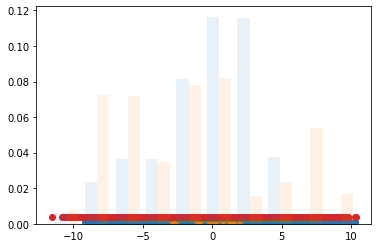

In [121]:
plt.hist(data, density=True, alpha=0.1)
for h in range(k):
    currd = data[allocs_out[-1] == h]
    plt.scatter(currd, np.zeros_like(currd) + 0.001 * (h+1))

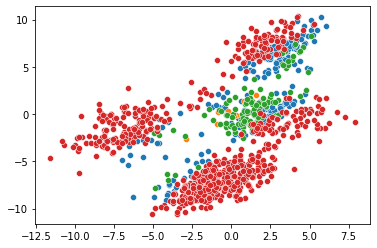

In [126]:
# usando pochi samples
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)

In [127]:
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in range(k)]

In [128]:
M

[[1.2757815, 1.9541196],
 [-0.016858868, 0.118646674],
 [1.1041073, 0.81665426],
 [-1.2240719, -2.915057]]

In [ ]:
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)
    

In [71]:
import arviz as az

In [82]:
means = [val[:,:,0] for val in uniq_vals_out]

In [80]:
uniq_vals_out[0][:,:,0]

array([[-0.710227  , -0.62251401],
       [-5.75104913, -5.73145088],
       [-4.33057612, -4.44616116],
       [ 2.69026134,  2.7092178 ]])

In [87]:
[mean[0,:] for mean in means]

[array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.62251401]),
 array([-0.710227  , -0.6225

In [86]:
means[0][0,:]

array([-0.710227  , -0.62251401])

In [88]:
means

[array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.69026134,  2.7092178 ]]),
 array([[-0.710227  , -0.62251401],
        [-5.75104913, -5.73145088],
        [-4.33057612, -4.44616116],
        [ 2.6902

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].plot(np.arange(len(uniq_vals_out)), means)
axes[0].set_title("Means", fontsize=16)

axes[1].vlines(np.arange(len(uniq_vals_out)), chains[:, 1] - 0.3, chains[:, 1] + 0.3)
axes[1].set_title("n", fontsize=16)

plt.show()

In [ ]:
chains_az = az.convert_to_inference_data(
    {"theta": chains[:, 0], "n": chains[:, 1]})

print(az.ess(chains_az))